Building Quantum Phase Estimation circuit...
Simulating the circuit...


C:\Users\user\AppData\Local\Temp\ipykernel_41952\2338372065.py:82: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(n_counting, inverse=True).to_gate()



Most probable measurement result (integer): 192
Estimated phase (φ): 0.7500
            ┌───┐ ░                                                            »
counting_0: ┤ H ├─░────■───────────────────────────────────────────────────────»
            ├───┤ ░    │                                                       »
counting_1: ┤ H ├─░────┼───────■───────────────────────────────────────────────»
            ├───┤ ░    │       │                                               »
counting_2: ┤ H ├─░────┼───────┼───────■───────────────────────────────────────»
            ├───┤ ░    │       │       │                                       »
counting_3: ┤ H ├─░────┼───────┼───────┼───────■───────────────────────────────»
            ├───┤ ░    │       │       │       │                               »
counting_4: ┤ H ├─░────┼───────┼───────┼───────┼────────■──────────────────────»
            ├───┤ ░    │       │       │       │        │                      »
counting_5: ┤ H ├─░────┼───────┼

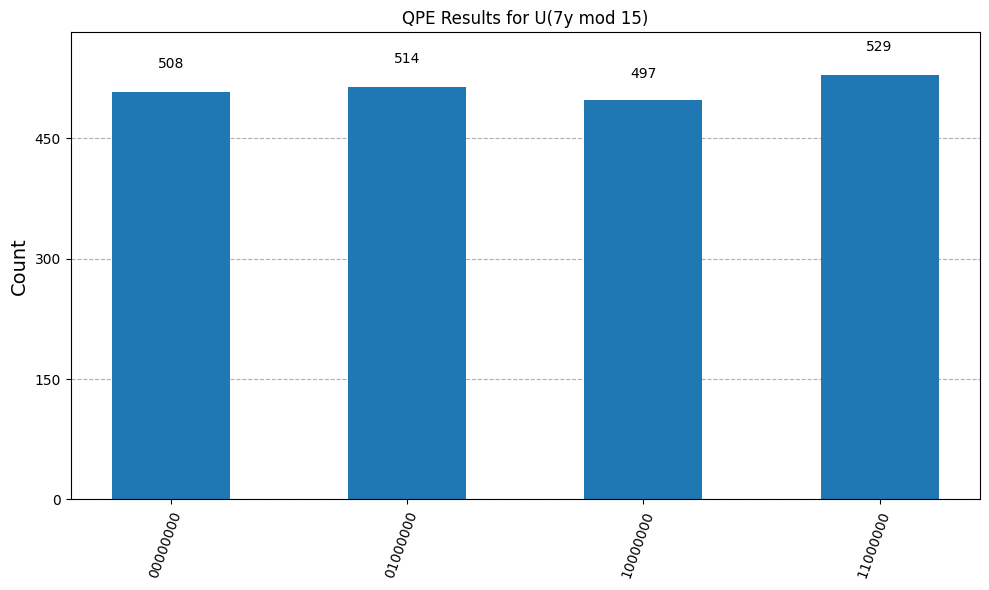

In [2]:
# =============================================================================
# Shor's Algorithm: Quantum Period-Finding Core
# Portfolio Demonstration
#
# This script implements the quantum part of Shor's algorithm for a simplified,
# illustrative case: finding the period of modular multiplication for a=7, N=15.
# The focus is on demonstrating the Quantum Phase Estimation (QPE) technique,
# which is the heart of Shor's quantum advantage.
# =============================================================================

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT
from fractions import Fraction
from typing import List

# Enables plots to be displayed inline in environments like Jupyter Notebooks
%matplotlib inline

# --- Step 1: Create the Unitary Operator U for a specific case ---

# --- Step 1: Create the Unitary Operator U for a specific case ---

def create_modular_multiplier_circuit(a: int, N: int) -> QuantumCircuit:
    """
    Creates the unitary operator U as a QuantumCircuit.
    This circuit performs the mapping |y> -> |a*y mod N> for a=7, N=15.
    """
    n_qubits = int(np.ceil(np.log2(N)))
    U = QuantumCircuit(n_qubits, name=f"U({a}*y mod {N})")

    # The same simplified logic for the permutation
    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)
    

    return U

# --- Step 2: Build the Quantum Phase Estimation (QPE) Circuit ---

def build_qpe_circuit(n_counting: int, a: int, N: int) -> QuantumCircuit:
    """
    Constructs the QPE circuit to find the phase of the modular multiplier U.
    """

    counting_qr = QuantumRegister(n_counting, name="counting")
    n_state = int(np.ceil(np.log2(N)))
    state_qr = QuantumRegister(n_state, name="state")
    classical_cr = ClassicalRegister(n_counting, name="c")
    
    qc = QuantumCircuit(counting_qr, state_qr, classical_cr)
    
    qc.h(counting_qr)
    qc.x(state_qr[0])
    qc.barrier()
    
    for j in range(n_counting):
        control_qubit = counting_qr[j]
        power = 2**j
        
        
        base_U_circuit = create_modular_multiplier_circuit(a, N)

        U_power_circuit = QuantumCircuit(n_state, name=f"U^{power}")

    
        for _ in range(power):
            U_power_circuit.compose(base_U_circuit, inplace=True)
            
        controlled_U_power = U_power_circuit.to_gate().control(1)
        
        
        qc.append(controlled_U_power, [control_qubit] + state_qr[:])
        
    qc.barrier()
    
    
    iqft_gate = QFT(n_counting, inverse=True).to_gate()
    qc.append(iqft_gate, counting_qr)
    qc.barrier()
    qc.measure(counting_qr, classical_cr)
    
    return qc

# --- Step 3: Simulation and Classical Post-Processing ---

def main():
    """Main execution function to run the period-finding demonstration."""
    
    # --- Algorithm Parameters ---
    N = 15
    a = 7
    # Use 2n qubits in the counting register for high precision, where n=log2(N).
    n_counting = 8
    
    # --- Circuit Construction and Simulation ---
    print("Building Quantum Phase Estimation circuit...")
    qpe_circuit = build_qpe_circuit(n_counting, a, N)
    
    # Optional: Print the circuit diagram to see its structure.
    # print(qpe_circuit)
    
    print("Simulating the circuit...")
    simulator = AerSimulator()
    transpiled_circuit = transpile(qpe_circuit, simulator)
    job = simulator.run(transpiled_circuit, shots=2048)
    result = job.result()
    counts = result.get_counts(transpiled_circuit)
    
    # --- Classical Post-Processing: Analyze Results ---
    # Find the most frequent measurement outcome.
    measured_str = max(counts, key=counts.get)
    measured_int = int(measured_str, 2)
    print(f"\nMost probable measurement result (integer): {measured_int}")
    
    # Convert the integer result into the estimated phase.
    phase = measured_int / (2**n_counting)
    print(f"Estimated phase (φ): {phase:.4f}")
    
    # Use the Continued Fractions algorithm to find the period 'r' from the phase.
    # The phase φ ≈ s/r. The Fraction class finds the best rational approximation.
    frac = Fraction(phase).limit_denominator(N)
    s = frac.numerator
    r = frac.denominator # This is our candidate for the period.
    
    print(qpe_circuit)
    print("\n--- Period Finding Results ---")
    print(f"Continued fraction approximation of phase: {s}/{r}")
    print(f"The estimated period (r) is: {r}")
    
    # Verify the result against the known correct period.
    if r == 4:
        print("Result is correct! The period was successfully found. ✅")
    else:
        print("Result is incorrect. This can happen due to measurement statistics or low precision.")

    # --- Visualization ---
    plot_histogram(counts, title=f"QPE Results for U({a}y mod {N})", figsize=(10, 6))
    plt.show()


if __name__ == "__main__":
    main()